In [42]:
from slvsh_tr import load_examples
import cv2
import matplotlib.pyplot as plt

examples = load_examples()



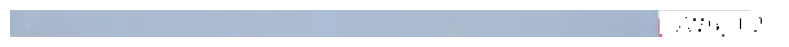

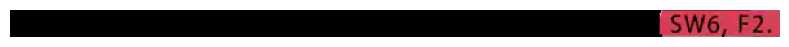

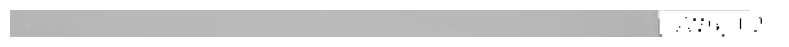

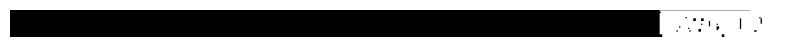

テキスト領域: (502, 0, 93, 21)


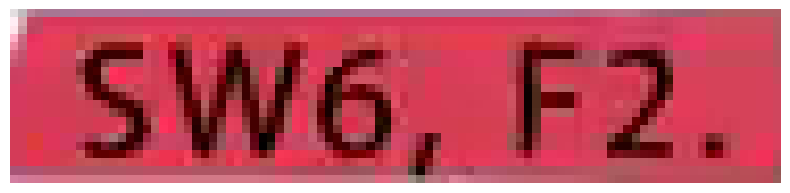

'SW6, F2.'

In [6]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitningRecognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_kinjiro_color(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）
        lower_red1 = np.array([0, 40, 40])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 40, 40])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_red1, mask_red2))
        
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.1 and h > height * 0.9:  # 高さの条件を変更
                text_regions.append((x, y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2])  # 幅が最大のものを選択
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_kinjiro_color(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            target_image = original_roi
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitningRecognizer(debug=True)
model.infer(examples[72].get_image())

In [5]:
from slvsh_tr import eval
import pandas as pd

model = TesseractFindRectWhitningRecognizer()
result = eval(model)

df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples: 100%|██████████| 178/178 [01:31<00:00,  1.94it/s]


precision    0.744961
recall       0.938532
f1           0.732063
dtype: float64

In [6]:
df.sort_values(by='precision').head(20)

,prediction,expected,precision,recall,f1
53,EE,,0.0,1.0,0.0
81,WR,,0.0,1.0,0.0
121,1,,0.0,1.0,0.0
74,"OU. , RR PARES",,0.0,1.0,0.0
72,NBS,NB5,0.0,0.0,0.0
71,T,"TT, BIO 5.",0.0,0.0,0.0
128,AF. 6CGUY,,0.0,1.0,0.0
32,",",,0.0,1.0,0.0
130,A,,0.0,1.0,0.0
45,6CU6UCUMKUCUCU COC OOO,,0.0,1.0,0.0


対象の矩形が結構正確にとれるので、矩形が見つからない時は空文字を返すようにする

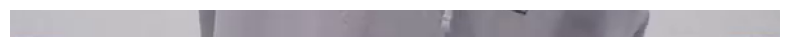

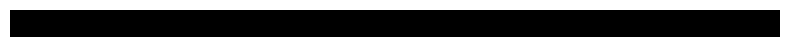

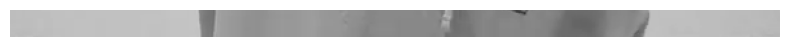

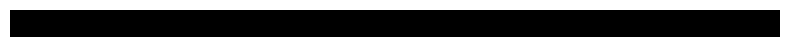

テキスト領域: None


''

In [11]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning2Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_kinjiro_color(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）
        lower_red1 = np.array([0, 40, 40])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 40, 40])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_red1, mask_red2))
        
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.1 and h > height * 0.9:  # 高さの条件を変更
                text_regions.append((x, y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2])  # 幅が最大のものを選択
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_kinjiro_color(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitning2Recognizer(debug=True)
model.infer(examples[45].get_image())

In [12]:
model = TesseractFindRectWhitning2Recognizer()
result = eval(model)
df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples: 100%|██████████| 178/178 [00:57<00:00,  3.12it/s]


precision    0.935972
recall       0.927296
f1           0.923074
dtype: float64

In [14]:
df.sort_values(by='precision').head(20)

,prediction,expected,precision,recall,f1
151,,B3S.,0.000000,0.000000,0.000000
74,T,"TT, BIO 5.",0.000000,0.000000,0.000000
71,,NB5,0.000000,0.000000,0.000000
116,", S0.",,0.000000,1.000000,0.000000
131,A,,0.000000,1.000000,0.000000
165,2 4,"UN 1, PRETZ 1.",0.000000,0.000000,0.000000
128,,FS.,0.000000,0.000000,0.000000
107,"SWS, BSA. B6.","SW5, B&A. B6.",0.666667,0.666667,0.666667
51,"BS,B2.","BS, B2.",0.666667,0.500000,0.571429
82,CORK 3 LEAD SAFETY.LAND HOLDING WCARVE.,CORK 3 LEAD SAFETY. LAND HOLDING W/CARVE.,0.750000,0.666667,0.705882


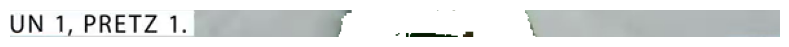

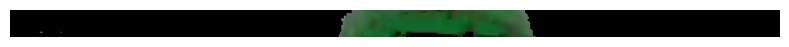

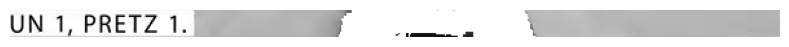

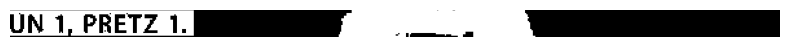

テキスト領域: (254, 0, 152, 21)


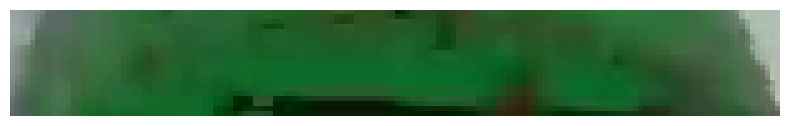

'2 4'

In [19]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning2Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_kinjiro_color(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）
        lower_red1 = np.array([0, 40, 40])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 40, 40])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_red1, mask_red2))
        
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.05 and h > height * 0.9:  # 高さの条件を変更
                text_regions.append((x, y, w, h))
        
        if text_regions:
            return max(text_regions, key=lambda r: r[2])  # 幅が最大のものを選択
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_kinjiro_color(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. "'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitning2Recognizer(debug=True)
model.infer(examples[164].get_image())

矩形が左端か右端に寄ってる前提を使う

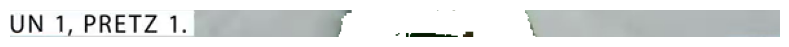

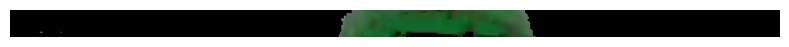

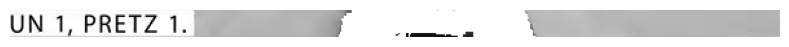

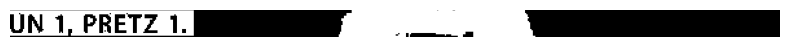

テキスト領域: (0, 1, 142, 19)


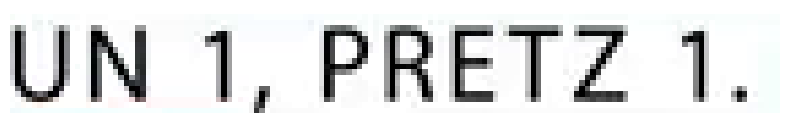

'UN 1, PRETZ 1.'

In [25]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning3Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_kinjiro_color(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）
        lower_red1 = np.array([0, 40, 40])
        upper_red1 = np.array([10, 255, 255])
        lower_red2 = np.array([170, 40, 40])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_red1, mask_red2))
        
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.05 and h > height * 0.9:
                # 右端または左端にアラインされているか確認
                if x < width * 0.05 or x + w > width * 0.95:
                    text_regions.append((x, y, w, h))
        
        if text_regions:
            # 幅が最大のものを選択
            return max(text_regions, key=lambda r: r[2])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_kinjiro_color(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. /"'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitning3Recognizer(debug=True)
model.infer(examples[164].get_image())

In [26]:
model = TesseractFindRectWhitning3Recognizer()
result = eval(model)



Evaluating examples: 100%|██████████| 178/178 [00:54<00:00,  3.26it/s]


In [27]:
df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

precision    0.955455
recall       0.946701
f1           0.942516
dtype: float64

In [28]:
df.sort_values(by='precision').head(20)

,prediction,expected,precision,recall,f1
127,A,,0.000000,1.000000,0.000000
71,T,"TT, BIO 5.",0.000000,0.000000,0.000000
76,NBS,NB5,0.000000,0.000000,0.000000
160,WIK,,0.000000,1.000000,0.000000
54,"BS,B2.","BS, B2.",0.666667,0.500000,0.571429
107,"SWS, BSA. B6.","SW5, B&A. B6.",0.666667,0.666667,0.666667
96,"PBS, OVER CLOSE","PB5, OVER CLOSE",0.750000,0.750000,0.750000
3,UN SWS5 NOSE.,REVENGE UN SW5 NOSE.,0.750000,0.600000,0.666667
123,BIO 6 SAFETY.,BIO 6 SAFETY,0.750000,1.000000,0.857143
64,"BS, F2.","BS, F2",0.750000,1.000000,0.857143


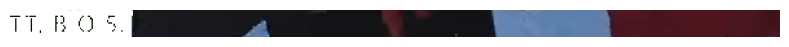

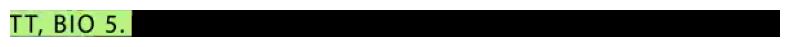

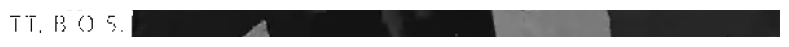

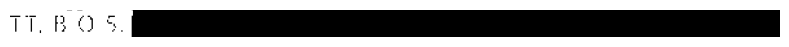

テキスト領域: (0, 0, 95, 21)


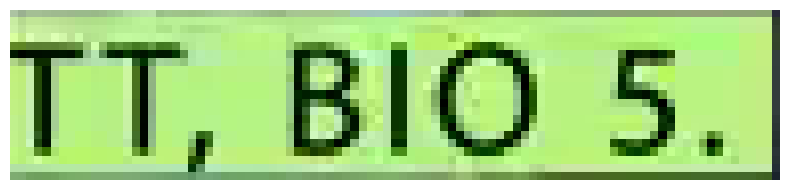

'TT, BIO 5S.'

In [31]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning4Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_red_and_green(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）- 明るい赤のみ
        lower_red2 = np.array([170, 100, 100])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, mask_red2)
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.05 and h > height * 0.9:
                # 右端または左端にアラインされているか確認
                if x < width * 0.05 or x + w > width * 0.95:
                    text_regions.append((x, y, w, h))
        
        if text_regions:
            # 幅が最大のものを選択
            return max(text_regions, key=lambda r: r[2])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_red_and_green(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. /"'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitning4Recognizer(debug=True)
model.infer(examples[74].get_image())

In [32]:
model = TesseractFindRectWhitning4Recognizer()
result = eval(model)

df = pd.DataFrame([r.model_dump() for r in result])
df.mean(numeric_only=True)

Evaluating examples: 100%|██████████| 178/178 [00:51<00:00,  3.45it/s]


precision    0.964430
recall       0.951850
f1           0.948673
dtype: float64

In [33]:
df.sort_values(by='precision').head(20)

,prediction,expected,precision,recall,f1
130,A,,0.000000,1.000000,0.000000
75,NBS,NB5,0.000000,0.000000,0.000000
162,WIK,,0.000000,1.000000,0.000000
55,"BS,B2.","BS, B2.",0.666667,0.500000,0.571429
109,"SWS, BSA. B6.","SW5, B&A. B6.",0.666667,0.666667,0.666667
124,BIO 6 SAFETY.,BIO 6 SAFETY,0.750000,1.000000,0.857143
62,"BS, F2.","BS, F2",0.750000,1.000000,0.857143
4,UN SWS5 NOSE.,REVENGE UN SW5 NOSE.,0.750000,0.600000,0.666667
102,"PBS, OVER CLOSE","PB5, OVER CLOSE",0.750000,0.750000,0.750000
64,L BIO 7. TAIL,"L BIO 7, TAIL",0.800000,0.800000,0.800000


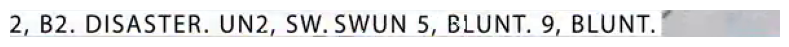

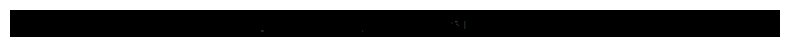

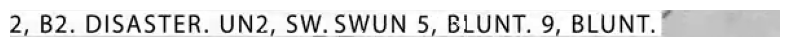

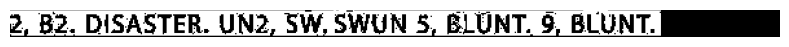

テキスト領域: (0, 0, 503, 20)


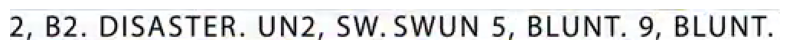

'2, B2. DISASTER. UN2. SW.SWUN 5, BLUNT. 9, BLUNT.'

In [43]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning4Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_red_and_green(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）- 明るい赤のみ
        lower_red2 = np.array([170, 100, 100])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, mask_red2)
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.05 and h > height * 0.9:
                # 右端または左端にアラインされているか確認
                if x < width * 0.05 or x + w > width * 0.95:
                    text_regions.append((x, y, w, h))
        
        if text_regions:
            # 幅が最大のものを選択
            return max(text_regions, key=lambda r: r[2])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_red_and_green(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. /"'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitning4Recognizer(debug=True)
model.infer(examples[31].get_image())